In [2]:
using LinearAlgebra
using Plots
using SparseArrays
using Arpack #Eigenvalues of sparse arrays with eigs()
using DifferentialEquations
# using DiffEqFlux
# using Optim
# using ForwardDiff
using DelimitedFiles
using LineSearches
using LaTeXStrings

In [3]:
#Def parameters
n_cutoff = 8
N = 2 * n_cutoff + 1
NHilbert = N^2
n = sparse(Diagonal(LinRange(-n_cutoff, n_cutoff, N))) #Perhaps implement using StaticArrays
# n = sparse(Diagonal(LinRange(n_cutoff, 3*n_cutoff+1, N))) #Perhaps implement using StaticArrays

Id = sparse(I, N, N)
exp_iPhi = spdiagm(-1 => ones(N - 1));

#Def Hamiltonian parameters
E_J_GHz = 10.0 #scale of E_J in units of h*GHz, h-bar = 1, h = 2pi
E_C = 1/100  #Charging energies
E_J = 1.0 #Josephson energies
phi_ext = 0.995pi

prefactor = 4 * E_C
Kinetic = 2pi * E_J_GHz * prefactor * (kron(n^2, Id) .+ kron(Id, n^2))

Potential1 = -2pi * E_J_GHz * kron(1 / 2 * (exp_iPhi .+ exp_iPhi'), Id) # -E_J1 cos(phi1)
Potential2 = -2pi * E_J_GHz * kron(Id, 1 / 2 * (exp_iPhi .+ exp_iPhi')) # -E_J2 cos(phi2)
Pot3Mat = kron(exp_iPhi, exp_iPhi')
Pot3Const = -2pi * E_J_GHz * E_J / 2

function get_Pot3(Φ_ext = phi_ext)
    M = exp(im * Φ_ext) * Pot3Mat
    return Pot3Const * (M + M')
end

function dPot3_dphi(Φ_ext = phi_ext)
    M = exp(im * Φ_ext) * Pot3Mat
    return (im * Pot3Const) .* (M - M')
end

Potential3 =  get_Pot3() #-E_J3 cos(phi1 - phi2 + phi_ext)
Potential12 = E_J * (Potential1 + Potential2)
KinPot12 = Kinetic + Potential12
chargecoupling = kron(n, Id);

In [4]:
function limit_func(param,pmin,pmax)
    (pmax - pmin) * (1/(1 + exp(-param))) + pmin
end

function inv_limit_func(param,pmin,pmax)
    # -log( (pmax - pmin  + 2e-8) / (param - pmin + 1e-8) - 1)
    -log( (pmax - pmin) / (param - pmin) - 1)
end

function alpha(p, t)
    Tₐ = 10#limit_func(p[2],0,15)
    Tₚ = 30 - 2*Tₐ#p[3]
    αmin = limit_func(p[1],0.5,1)
    abs_slope = (1 - αmin)/Tₐ
    if t < Tₐ
        return 1 - abs_slope * t
    elseif t > Tₐ + Tₚ
        return αmin + abs_slope * (t - Tₐ - Tₚ)
    else
        return αmin
    end
end

h_times = LinRange(10,20,50+2)[2:end-1]
dt = h_times[2] - h_times[1]
function pulse(p, t)
    if  t < 10 || t > 20
        return 0
    end
    out = 0
    w_start = exp( - 5/(2*dt^2) * (t - 10)^2)
    w_end = exp( - 5/(2*dt^2) * (t - 20)^2)
    w_sum = w_start + w_end
    for (i, ht) in enumerate(h_times)
        w = exp( - 5/(2*dt^2) * (t - ht)^2)
        out += p[i+1] * w
        w_sum += w
    end
    # envelope(t)*out/w_sum
    out/w_sum
end

pulse (generic function with 1 method)

In [20]:
ps = readdlm("tmp_awg55_paramsN5.txt")
# ps = readdlm("..\\RobustPhiExt\\tmp_awg55_paramsm0.txt")
# ps = readdlm("..\\RobustPhiExt\\tmpC_awg55_paramsm4.txt")
# ps = readdlm("..\\RobustPhiExt\\tmpC2_awg55_paramsRm4.txt")

phis = readdlm("..\\RobustPhiExt\\phis.txt")#LinRange(0.993,0.997,21)
times = LinRange(0,30,2000) ;

p = copy(ps[end,:]) ;

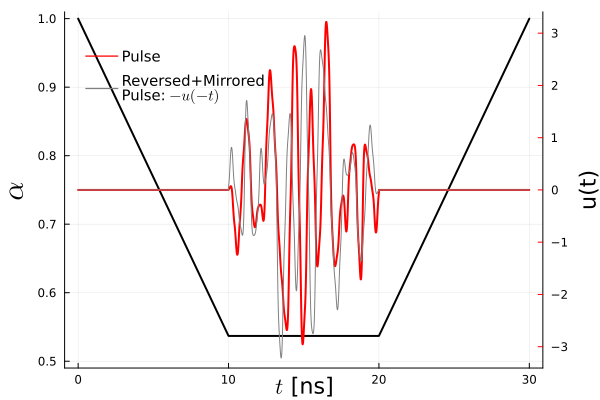

In [97]:
pulse_plot = plot(times,
     [alpha(p,t) for t in times],
     ylim=(0.49,1.01),
     linewidth=2,
     color="black",label=nothing,
     labelfontsize=20,ticklabelfontsize=20,
      ylabel=L"$\alpha$",figsize=(1000,500))

t_scale = round(Int,limit_func(p[2],0,15)/30 * 1000)
plot!(twinx(),
      times,
      # [pulse(p,t) for t in times],
      [[pulse(p,t) for t in times],
            [-pulse(p,t) for t in times[end:-1:1]],
            # [pulse(ps[end-j,:],t) for t in times],
            # [-pulse(ps[end-j,:],t) for t in times[end:-1:1]]
      ],
      linewidth=[2 1],
      color=[:red :grey],
      # ylim=(-2.5,2.5),
      ls = [:solid :solid],
      alpha=[1 1],
      label=["Pulse" "Reversed+Mirrored"*"\n"*L"Pulse: $-u(-t)$"],
      legend=:topleft,
      background_color_legend = nothing,
      foreground_color_legend = nothing,
      legendfontsize=10,
      labelfontsize=15,
      ticklabelfontsize=15,
      xlabel=L"$t$ [ns]",
      axiscolor=:red,
      ylabel="u(t)")

In [8]:
Es = eigvals(Matrix(KinPot12 + Potential3))
ψs = eigvecs(Matrix(KinPot12 + Potential3));

function f!(du, u, p, t)
    du[:] = -im .* ((KinPot12 + alpha(p,t) .* Potential3 + pulse(p,t) .* chargecoupling) * u)
end

forward_prob = ODEProblem(f!, ψs[:,1:2], (0.0, 30.0), p)
sol_f = solve(forward_prob, p=p, saveat=times, reltol=1e-10, abstol=1e-10) ;

In [9]:
occs = zeros(Float64,length(sol_f.t),2,2)

# M1 = Matrix(KinPot12)
# M2 = Matrix(Potential3)
for (i,t) in enumerate(sol_f.t)
    tmp_Es, tmp_ψs = eigs(KinPot12 + alpha(p,t) .* Potential3, nev=2, which=:SR, tol=0.0, maxiter=10000);
    # tmp_ψs = eigvecs(M1 + alpha(p,t) .* M2)
    occs[i,:,:] = abs2.(tmp_ψs'*sol_f.u[i])
end

In [10]:
colors = ["#0F956F" "#BA2936" "#000852"]
# colors = ["#16866A" "#AF1B3F" "#40737A"]

1×3 Matrix{String}:
 "#0F956F"  "#BA2936"  "#000852"

┌ Warning: Invalid negative or zero value -2.4424906541753444e-15 found at series index 1 for log10 based yscale
└ @ Plots C:\Users\jv97\.julia\packages\Plots\jqILG\src\utils.jl:85
┌ Warning: Invalid negative or zero value -2.4424906541753444e-15 found at series index 1 for log10 based yscale
└ @ Plots C:\Users\jv97\.julia\packages\Plots\jqILG\src\utils.jl:85


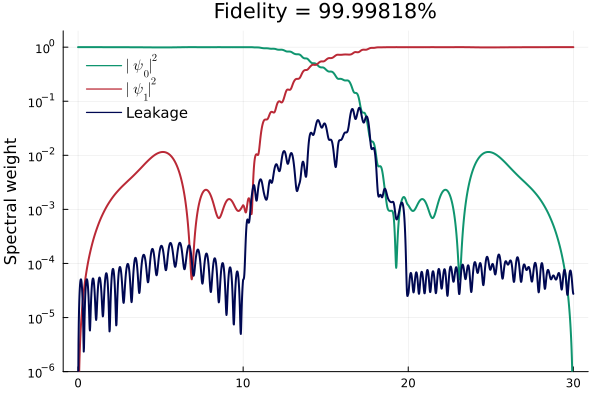

┌ Warning: Invalid negative or zero value -2.4424906541753444e-15 found at series index 1 for log10 based yscale
└ @ Plots C:\Users\jv97\.julia\packages\Plots\jqILG\src\utils.jl:85


In [11]:
Occs_plot = plot(sol_f.t,
     [occs[:,:,1],1 .- sum(occs[:,:,1],dims=2)],
     yscale=:log10,
     ylim=(1e-6,2),
     color=colors,
     legend=:topleft,
     background_color_legend = nothing,
     foreground_color_legend = nothing,
     legendfontsize=10,
     lw=2,
     # legend=nothing,
     label=[L"$|\psi_0|^2$" L"|\psi_1|^2" "Leakage"],
     title = "Fidelity = "*string((1 - 0.5*(2-occs[end,1,2] - occs[end,2,1]))*100)[1:8]*"%",
     # xlabel="Time [ns]",
     ylabel="Spectral weight",figsize=(1000,500))

┌ Warning: Invalid negative or zero value -2.4424906541753444e-15 found at series index 1 for log10 based yscale
└ @ Plots C:\Users\jv97\.julia\packages\Plots\jqILG\src\utils.jl:85
┌ Warning: Invalid negative or zero value -2.4424906541753444e-15 found at series index 1 for log10 based yscale
└ @ Plots C:\Users\jv97\.julia\packages\Plots\jqILG\src\utils.jl:85


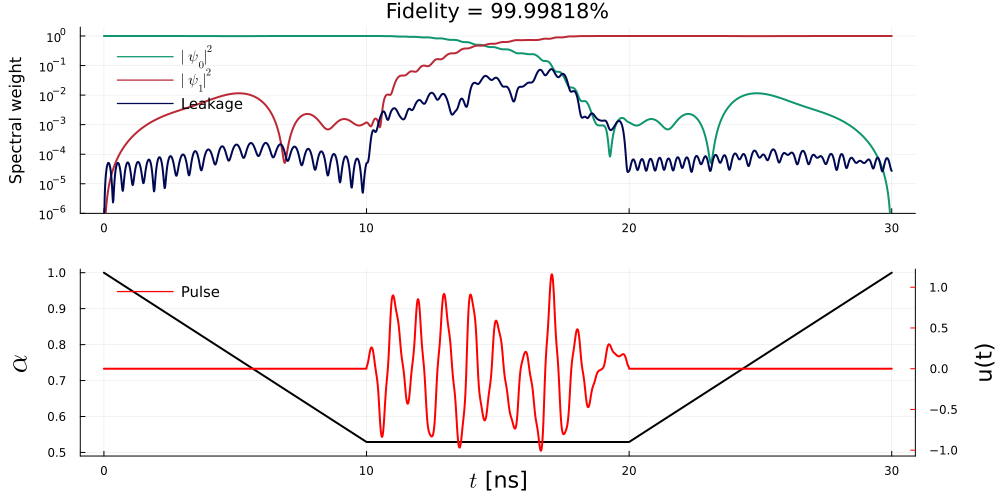

┌ Warning: Invalid negative or zero value -2.4424906541753444e-15 found at series index 1 for log10 based yscale
└ @ Plots C:\Users\jv97\.julia\packages\Plots\jqILG\src\utils.jl:85


In [96]:
using Plots.PlotMeasures
plt = plot(Occs_plot,pulse_plot,layout=(2,1),size=(1000,500),bottom_margin=20px,right_margin=20px,left_margin=20px)

In [98]:
# savefig(plt,"plot2_awg55Rm4.pdf")

┌ Warning: Invalid negative or zero value -2.4424906541753444e-15 found at series index 1 for log10 based yscale
└ @ Plots C:\Users\jv97\.julia\packages\Plots\jqILG\src\utils.jl:85


"c:\\Users\\jv97\\github\\Quantum-Optimal-Control\\Production\\RobustBySampling\\plot2_awg55Rm4.pdf"

In [21]:
function fidel(phi_ext,ps)
    Potential3 = get_Pot3(phi_ext)
    Es, ψs = eigs(KinPot12 + Potential3, nev=2, which=:SR, tol=0.0, maxiter=10000);

    function H!(du, u, p, t)
        du[:] = - im * (KinPot12 + alpha(p,t) .* Potential3 + pulse(p,t) .* chargecoupling) * u
    end

    forward_prob = ODEProblem(H!, ψs, (0.0, 30.0), ps)
    sol = solve(forward_prob, p=ps, save_everystep=false, reltol=1e-10, abstol=1e-10)

    UT = abs2.(ψs'*sol.u[end])
    return 0.5 * (2 - UT[1,2] - UT[2,1])
end

fidel (generic function with 1 method)

In [22]:
tmp_losses_N5 = []
for phi in phis
    push!(tmp_losses_N5,fidel(phi*pi,p))
end

In [23]:
# m4 = readdlm("..\\RobustPhiExt\\Phils_Cawg55m4.txt") ;
# # N5 = readdlm("..\\RobustPhiExt\\Phils_awg55N5.txt") ;
# m0 = readdlm("..\\RobustPhiExt\\Phils_awg55m0.txt") ;
# writedlm("..\\RobustPhiExt\\Phils_awg55N5.txt",tmp_losses_N5)

In [94]:
function fit(phis)
    1e3*(phis-0.995)^2 + minimum(tmp_losses)
end

fit (generic function with 1 method)

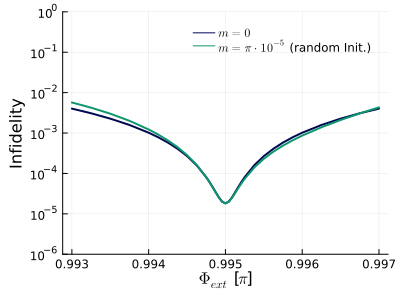

In [95]:
plt=plot(phis,
     [fit.(phis),tmp_losses],# [m0, tmp_losses,tmp_losses_N5],
     yscale=:log10,
     background_color_legend = nothing,
     foreground_color_legend = nothing,
     ylim=(1e-6,1),
     xlabel=L"$\Phi_{ext}$ [$\pi$]",
     ylabel="Infidelity",
     color=["#000852" "#0F956F" "#BA2936"],
     # xticks=[0.995-1e-5,0.995+1e-4],
     lw=2,
     label=[L"$m=0$" L"$m=\pi\cdot10^{-5}$ (random Init.)" "Robust by sampling"],
     size=(400,300)
     )
# plot!(phis,m4,
#       c= "#0F956F",
#       ls=:dash,
#       label= L"$m=\pi\cdot10^{-5}$ (zero init.)")

In [38]:
# savefig(plt,"Phils_awg55_Rm4.pdf")

"c:\\Users\\jv97\\github\\Quantum-Optimal-Control\\Production\\RobustBySampling\\Phils_awg55_Rm4.pdf"

In [104]:
phis2 = readdlm("../RobustPhiExt/phis.txt")
m4 = readdlm("..\\RobustPhiExt\\Phils_Cawg55m4.txt") ;
adj = readdlm("..\\RobustPhiExt\\Phils_awg55m2.txt") ;
m0 = readdlm("..\\RobustPhiExt\\Phils_awg55m0.txt") ;

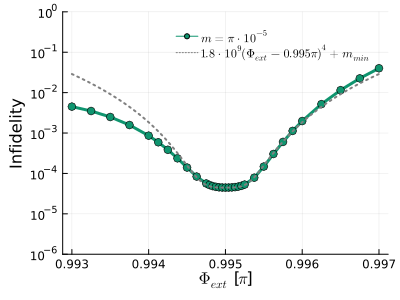

In [196]:
plt = plot(phis2, [m4],yscale=:log10,ylim=(1e-6,1),lw=3,marker=:o,size=(400,300),color=colors[1],label=L"$m=\pi\cdot10^{-5}$",
ylabel="Infidelity",fontsize=10,xlabel=L"$\Phi_{ext}$ [$\pi$]",
background_color_legend = nothing,
      foreground_color_legend = nothing,)

function fit(x)
    1.8e9*(x-0.995)^4 + minimum(m4)
end
phis = LinRange(0.993,0.997,100)
plot!(phis, fit.(phis),lw=2,color=:grey,ls=:dot,label=L"$1.8\cdot10^9(\Phi_{ext}-0.995\pi)^4+m_{min}$")

In [188]:
# savefig(plt,"Phils_awg55_m4_Fitted.pdf")

"c:\\Users\\jv97\\github\\Quantum-Optimal-Control\\Production\\RobustBySampling\\Phils_awg55_m4_Fitted.pdf"

In [133]:
ls = readdlm("tmp_awg55_lsN5.txt") ;

In [134]:
# phiLs = readdlm("..\\RobustPhiExt\\m4_phi.txt")

5-element Vector{Float64}:
 0.9996728457113122
 0.9986382625723776
 0.9974570229396762
 0.9970136911514479
 0.9969187473332897

In [136]:
a = Animation()
phis_anim = LinRange(0.994,0.996,5)
	
for i in 1:size(ps)[1]
    plt1 = plot(times,[pulse(ps[i,:],t) for t in times],ylim=(-3.75,3.75))
    plt2 = plot(phis_anim, ls[i,:],marker=:o,yscale=:log10,ylim=(1e-6,1))
    plt = plot(plt1,plt2,layout=(2,1),size=(1000,500))#,bottom_margin=20px,right_margin=20px,left_margin=20px)
    frame(a, plt)
end

gif(a,"anim.mp4")

┌ Info: Saved animation to c:\Users\jv97\github\Quantum-Optimal-Control\Production\RobustBySampling\anim.mp4
└ @ Plots C:\Users\jv97\.julia\packages\Plots\jqILG\src\animation.jl:149


Plots.AnimatedGif("c:\\Users\\jv97\\github\\Quantum-Optimal-Control\\Production\\RobustBySampling\\anim.mp4")

In [8]:
function envelopes!(E, Edot, Tᵣ, Tₐ, Tₚ, t)
    if Tₐ < t < Tₐ + Tᵣ
        arg = pi / 2 * (t - Tₐ) / Tᵣ
        E *= sin(arg)^2
        Edot *= 2*sin(arg)*cos(arg)*pi/(2*Tᵣ)
    elseif Tₐ + Tᵣ <= t <= Tₐ + Tₚ - Tᵣ
        E *= 1
        Edot *= 0
    elseif Tₐ + Tₚ - Tᵣ < t < Tₐ + Tₚ
        arg = pi / 2 * (Tₐ + Tₚ - t) / Tᵣ
        E *= sin(arg)^2
        Edot *= 2*sin(arg)*cos(arg)*(-pi)/(2*Tᵣ)
    else
        E *= 0
        Edot *= 0
    end
    return (E, Edot)
end

Es07 = eigvals(Matrix(KinPot12 + 0.7 .* Potential3))
ψs07 = eigvecs(Matrix(KinPot12 + 0.7 .* Potential3));

function DRAGalpha(t)
    Tₐ = 10#limit_func(p[2],0,15)
    Tₚ = 30 - 2*Tₐ#p[3]
    αmin = 0.7#limit_func(p[1],0.5,1)
    abs_slope = (1 - αmin)/Tₐ
    if t < Tₐ
        return 1 - abs_slope * t
    elseif t > Tₐ + Tₚ
        return αmin + abs_slope * (t - Tₐ - Tₚ)
    else
        return αmin
    end
end

function DRAGpulse(df,t)
    if t < 10 || t > 20
        return 0
    end
    Tₐ = 10#limit_func(p[2],0,15)
    Tₚ = 30 - 2*Tₐ#p[3]
    Tᵣ = 2#limit_func(p[1],0,Tₚ/2)
    # αmin = p[4]
    ϕ = 0#p[5]
    f = df*real(Es07[2] - Es07[1])#p[6]
    A = 1.0/abs(ψs07[:,1]'*chargecoupling*ψs07[:,2])#p[7]
    # Φ_ext = p[8]
    # λ = p[9]

    amp = pi * A / (Tₚ - Tᵣ)
    E = amp
    Edot = copy(amp)
    E, Edot = envelopes!(E, Edot, Tᵣ, Tₐ, Tₚ, t)
    arg = f*(t - Tₐ) + ϕ
    return E*cos(arg) #+ Edot*λ*sin(arg)
end
# dfF = []
# for df in LinRange(0.97,0.98,10)
#     function f!(du, u, p, t)
#         du[:] = -im .* ((KinPot12 + DRAGalpha(t) .* Potential3 + DRAGpulse(df,t) .* chargecoupling) * u)
#     end

#     forward_prob = ODEProblem(f!, ψs[:,1:2], (0.0, 30.0), p)
#     sol_f = solve(forward_prob, p=p, save_everystep=false, reltol=1e-10, abstol=1e-10) ;
#     UT = abs2.(ψs[:,1:2]'*sol_f.u[end])
#     push!(dfF,0.5*(2-UT[1,2] - UT[2,1]))
# end
function f!(du, u, p, t)
    du[:] = -im .* ((KinPot12 + DRAGalpha(t) .* Potential3 + DRAGpulse(0.9778,t) .* chargecoupling) * u)
end

forward_prob = ODEProblem(f!, ψs[:,1:2], (0.0, 30.0), p)
sol_f = solve(forward_prob, p=p, saveat=times, reltol=1e-10, abstol=1e-10) ;

In [231]:
dfF[8],LinRange(0.97,0.98,10)[8]

(9.77310629949324e-5, 0.9777777777777777)

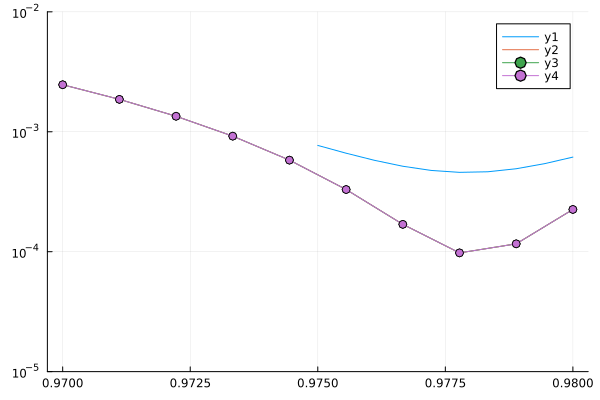

In [223]:
plot!(LinRange(0.97,0.98,10),dfF,yscale=:log10,ylim=(1e-5,1e-2),marker=:o)

In [11]:
occs = zeros(Float64,length(sol_f.t),2,2)

for (i,t) in enumerate(sol_f.t)
    tmp_Es, tmp_ψs = eigs(KinPot12 + DRAGalpha(t) .* Potential3, nev=2, which=:SR, tol=0.0, maxiter=10000);
    occs[i,:,:] = abs2.(tmp_ψs'*sol_f.u[i])
end

In [258]:
0.5*(2-occs[end,1,2] - occs[end,2,1])

9.722110036747278e-5

┌ Warning: Invalid negative or zero value -2.4424906541753444e-15 found at series index 1 for log10 based yscale
└ @ Plots C:\Users\jv97\.julia\packages\Plots\jqILG\src\utils.jl:85


┌ Warning: Invalid negative or zero value -2.4424906541753444e-15 found at series index 1 for log10 based yscale
└ @ Plots C:\Users\jv97\.julia\packages\Plots\jqILG\src\utils.jl:85


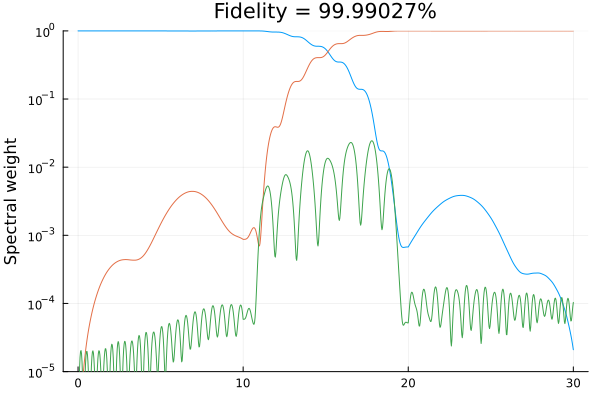

┌ Warning: Invalid negative or zero value -2.4424906541753444e-15 found at series index 1 for log10 based yscale
└ @ Plots C:\Users\jv97\.julia\packages\Plots\jqILG\src\utils.jl:85


In [12]:
Occs_plot = plot(sol_f.t,
     [occs[:,:,1],1 .- sum(occs[:,:,1],dims=2)],
     yscale=:log10,
     ylim=(1e-5,1),
     legend=nothing,
     title = "Fidelity = "*string((1 - 0.5*(2-occs[end,1,2] - occs[end,2,1]))*100)[1:8]*"%",
     # xlabel="Time [ns]",
     ylabel="Spectral weight",figsize=(1000,500))

In [14]:
Estmp = eigvals(Matrix(KinPot12 + 0.7265360232227066 .* Potential3))
ψstmp = eigvecs(Matrix(KinPot12 + 0.7265360232227066 .* Potential3));

2.0448639414672374/real(Estmp[2] - Estmp[1]), 4.08982325027897*abs(ψstmp[:,1]'*chargecoupling*ψstmp[:,2])

(0.9719035351237967, 1.0167113829855654)

In [ ]:
p = [1.8096066788458205,
10.151415509076779,
10.0,
0.7265360232227066,
2.819743639160394,
2.0448639414672374,
4.08982325027897,
3.1258846903218442,
0.03571156893603993];